***PART A: Embeddings***

In [4]:
pip install node2vec

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from node2vec import Node2Vec

*Load the Dataset*

In [6]:
edges_file = "./main-edges-email-sna.csv"

In [7]:
edges = pd.read_csv(edges_file)

In [8]:
edges

,Source,Target,Type,Id,Label,Weight
0,0,1,Directed,0,NaN,1
1,2,3,Directed,1,NaN,1
2,2,4,Directed,2,NaN,1
3,5,6,Directed,3,NaN,1
4,5,7,Directed,4,NaN,1
...,...,...,...,...,...,...
25566,420,143,Directed,25566,NaN,1
25567,174,859,Directed,25567,NaN,1
25568,440,460,Directed,25568,NaN,1
25569,52,786,Directed,25569,NaN,1


In [9]:
G = nx.from_pandas_edgelist(edges, source='Source',
                            target='Target', create_using=nx.DiGraph())

In [10]:
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 1005 nodes and 25571 edges.


*Shallow Node Embedding (Using Node2Vec)*

In [11]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

In [12]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [13]:
print(f"Each node is embedded into a {model.wv.vector_size}-dimensional space.")

Each node is embedded into a 64-dimensional space.


In [14]:
node_embedding = model.wv

In [15]:
for node, embedding in zip(list(G.nodes())[:5], node_embedding.vectors[:5]):
    print(f"Node {node}: Embedding: {embedding}")

Node 0: Embedding: [-0.28095317 -0.23579527  0.49034095  0.5235348  -0.6431646  -0.28342798
 -0.27850562  1.0228467  -0.28210956  0.65032977  0.10991112 -0.9352104
  0.35066843  0.70801    -0.32879826  0.539698   -0.38296136 -0.00200695
 -0.26952842 -0.12482564  0.42869794  0.829068    0.22914076 -0.13333781
 -0.48300096 -0.6740792   0.22751252 -0.28168267  0.23267837 -0.5007659
  0.15625201  0.51233745  0.04633116 -0.33445883 -0.35113174 -0.04506399
 -0.54599714  0.15694146 -0.31950778 -0.16789153  0.5775846   0.6511676
 -0.55923796 -0.5744458   0.09748171 -0.58234406 -0.5211761   0.40961516
 -0.10454108  0.06642125  0.08419278  0.5300587  -0.20530574  0.81367457
  0.4638662  -0.33949414 -0.25393626 -0.2912862  -0.2323324   0.00926821
 -0.19949976 -0.4452995  -0.35597005 -0.04220882]
Node 1: Embedding: [ 0.3128273  -0.46955538 -0.2855056   1.1325419  -0.47359356 -0.4772632
  0.4162572  -0.3882747   0.04993649  0.22428307  0.6129755   0.11197253
  0.2558248  -0.47291762  0.13643844  0.

*Deep Node Embedding Using*

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import from_networkx

In [30]:
class DeepGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers): # Corrected method name to __init__
        super(DeepGraphSAGE, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        activations = []
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            activations.append(x)
            x = F.dropout(x, p=0.5, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x, activations

In [27]:
data = from_networkx(G)
data = Data(edge_index=data.edge_index, num_nodes=G.number_of_nodes())

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepGraphSAGE(in_channels=1, hidden_channels=64, out_channels=128, num_layers=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [33]:
node_to_id = {node: i for i, node in enumerate(G.nodes())}
edges_numeric = [(node_to_id[u], node_to_id[v]) for u, v in G.edges()]
edge_index = torch.tensor(edges_numeric, dtype=torch.long).t().contiguous().to(device)

Epoch 1, Loss: 1.0768
Epoch 11, Loss: 0.9992
Epoch 21, Loss: 0.9999
Epoch 31, Loss: 0.9998
Epoch 41, Loss: 1.0007
Epoch 51, Loss: 1.0000
Epoch 61, Loss: 0.9993
Epoch 71, Loss: 0.9996
Epoch 81, Loss: 1.0001
Epoch 91, Loss: 0.9997
Epoch 101, Loss: 0.9999
Epoch 111, Loss: 1.0000
Epoch 121, Loss: 1.0005
Epoch 131, Loss: 1.0004
Epoch 141, Loss: 0.9989
Epoch 151, Loss: 1.0006
Epoch 161, Loss: 1.0011
Epoch 171, Loss: 0.9992
Epoch 181, Loss: 0.9992
Epoch 191, Loss: 0.9997


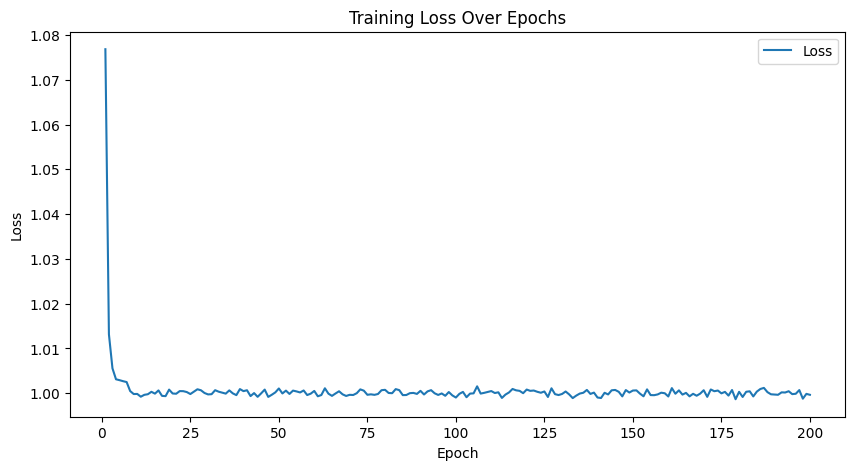

In [34]:
loss_history = []
embedding_history = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out, activations = model(x, edge_index)
    loss = F.mse_loss(out, torch.randn(out.size(), device=device))
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    embedding_history.append(out.detach().cpu().numpy())

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, 201), loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

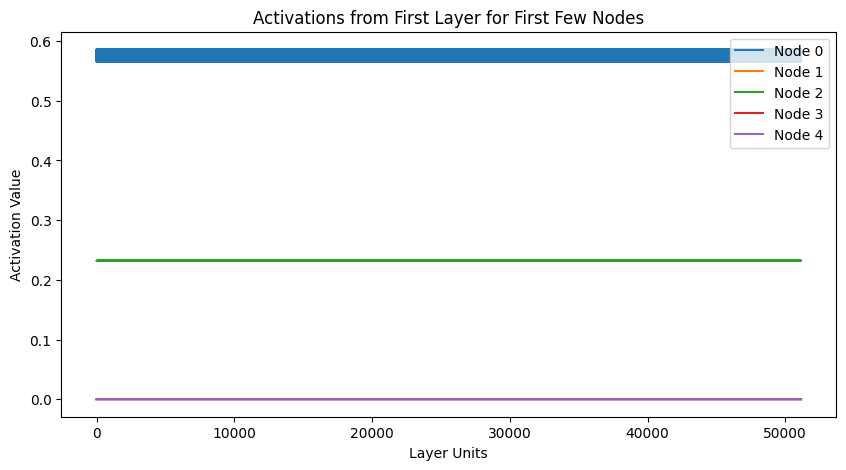

In [35]:
first_layer_activations = activations[0].detach().cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(min(5, first_layer_activations.shape[1])):
    plt.plot(first_layer_activations[:, i], label=f'Node {i}')
plt.xlabel('Layer Units')
plt.ylabel('Activation Value')
plt.title('Activations from First Layer for First Few Nodes')
plt.legend()
plt.show()

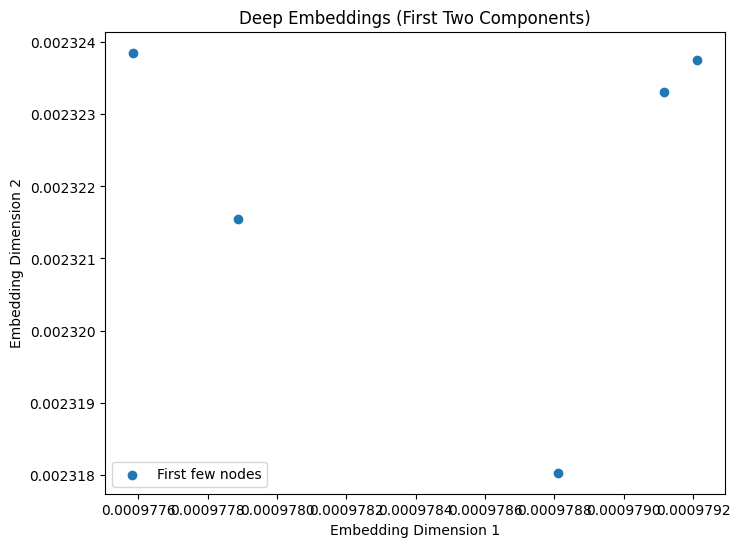

In [36]:
deep_embeddings = embedding_history[-1]
plt.figure(figsize=(8, 6))
plt.scatter(deep_embeddings[:5, 0], deep_embeddings[:5, 1], label='First few nodes')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Deep Embeddings (First Two Components)')
plt.legend()
plt.show()

In [37]:
print("Deep Embeddings for the first few nodes:")
print(deep_embeddings[:5])

Deep Embeddings for the first few nodes:
[[ 9.79114790e-04  2.32330849e-03 -1.85294833e-03  1.28551328e-03
   1.51776394e-03 -7.90024293e-04 -1.05115410e-03 -1.02200056e-03
  -5.19277528e-03  2.47851829e-03  1.03246339e-03 -3.01070628e-03
   4.46754554e-03 -5.29740006e-03 -1.10345529e-04  1.57317251e-03
   1.50093855e-03  2.15408765e-03  1.12797762e-03 -2.71260971e-03
   3.40746786e-03 -1.98232289e-03  2.69167521e-03 -2.25689402e-03
   3.22363805e-03 -6.03408599e-03  4.73991549e-03 -2.67668604e-03
   1.74063127e-04  3.33329360e-03 -4.47651655e-06 -1.45701738e-03
   2.01720768e-03  2.57513864e-04 -2.39251857e-03  2.59396038e-04
  -7.25684571e-04 -2.54009082e-03 -1.11920969e-03  1.93140339e-04
   2.20235297e-03  2.81574630e-05  6.21865445e-04 -3.62265110e-03
  -1.65146135e-03 -1.16063049e-03  3.83072905e-03  2.11270945e-03
  -6.81465818e-03  1.19835918e-03  1.95720978e-03  4.86076297e-03
  -2.09777863e-04  1.91844403e-04  6.63624029e-04  1.76153076e-03
   3.81989375e-04  1.67704478e-03  

*Display Model Information*

In [38]:
print(model)

print(f"Shallow Embeddings Shape: {node_embedding.vectors.shape}")
print(f"Deep Embeddings Shape: {deep_embeddings.shape}")

DeepGraphSAGE(
  (convs): ModuleList(
    (0): SAGEConv(1, 64, aggr=mean)
    (1-2): 2 x SAGEConv(64, 64, aggr=mean)
    (3): SAGEConv(64, 128, aggr=mean)
  )
)
Shallow Embeddings Shape: (1005, 64)
Deep Embeddings Shape: (51144, 128)


***PART B: Node Classification***

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import NormalizeFeatures

*Load the Cora dataset*

In [ ]:
dataset = Planetoid(root=".", name="Cora", transform=NormalizeFeatures())

Processing...
Done!


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

*Define the GCN model*

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

*Define the training function*

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

*Define the test function*

In [ ]:
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

*Initialize the model, optimizer, and accuracy list*

In [ ]:
model = GCN(in_channels=dataset.num_node_features, hidden_channels=128, out_channels=dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4)

*Train the model for 1500 epochs*

*Print the best accuracy achieved during training*

In [ ]:
best_test_acc = 0
for epoch in range(1500):
    loss = train()
    test_acc = test()
    best_test_acc = max(best_test_acc, test_acc)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}")

print(f"Best Test Accuracy: {best_test_acc:.4f}")

Epoch 1, Loss: 1.9463, Test Accuracy: 0.3730
Epoch 2, Loss: 1.8899, Test Accuracy: 0.2370
Epoch 3, Loss: 1.8009, Test Accuracy: 0.4780
Epoch 4, Loss: 1.6676, Test Accuracy: 0.6910
Epoch 5, Loss: 1.5289, Test Accuracy: 0.7880
Epoch 6, Loss: 1.3630, Test Accuracy: 0.7980
Epoch 7, Loss: 1.1896, Test Accuracy: 0.7630
Epoch 8, Loss: 1.0221, Test Accuracy: 0.7780
Epoch 9, Loss: 0.8832, Test Accuracy: 0.8120
Epoch 10, Loss: 0.7427, Test Accuracy: 0.8260
Epoch 11, Loss: 0.6263, Test Accuracy: 0.8200
Epoch 12, Loss: 0.5338, Test Accuracy: 0.8030
Epoch 13, Loss: 0.4525, Test Accuracy: 0.8170
Epoch 14, Loss: 0.4050, Test Accuracy: 0.8310
Epoch 15, Loss: 0.3724, Test Accuracy: 0.8240
Epoch 16, Loss: 0.3578, Test Accuracy: 0.8170
Epoch 17, Loss: 0.2919, Test Accuracy: 0.8070
Epoch 18, Loss: 0.2738, Test Accuracy: 0.7950
Epoch 19, Loss: 0.2711, Test Accuracy: 0.8070
Epoch 20, Loss: 0.2588, Test Accuracy: 0.8200
Epoch 21, Loss: 0.2696, Test Accuracy: 0.8110
Epoch 22, Loss: 0.2600, Test Accuracy: 0.79